# Numerical optimization for Maximum Likelihood estimation
#### Author: Mattias Villani, http://mattiasvillani.com

## Intro to numerical optimization - Rosenbrock's function

In [17]:
import numpy as np
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt

Let's first get to know the optimize function in Scipy by finding the minimum of the Rosenbrock function in three arguments:
$$ f(x_1,x_2,x_3) = 100(x_1^2-x_2)^2 + (x_1-1)^2 + 100(x_2^2-x_3)^2 + (x_2-1)^2$$

Here is the function definition of the Rosenbrock function:

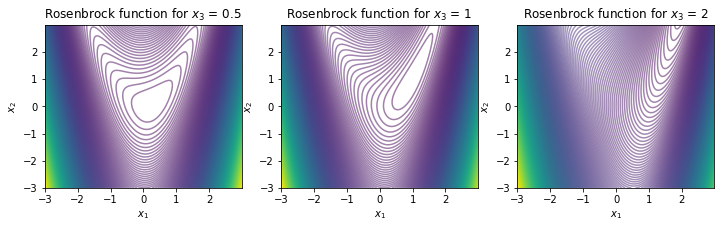

In [18]:
Rosenbrock = lambda x,par : par[0]*(x[0]-x[1]**2)**2 + (1-x[0])**2 + par[1]*(x[1]-x[2]**2)**2 + (1-x[1])**2

x1Grid = np.arange(-3,3,0.01)
x2Grid = np.arange(-3,3,0.01)
x1Mesh, x2Mesh = np.meshgrid(x1Grid, x2Grid)

plt.figure(figsize=(12,3))

for count,x3 in enumerate((0.5,1,2)):
    rosenbrockEvals = np.zeros((len(x1Grid),len(x2Grid)))
    for count1, x1 in enumerate(x1Grid):
        for count2, x2 in enumerate(x2Grid):
            rosenbrockEvals[count1,count2] = Rosenbrock((x1,x2,x3),(100,100))

    plt.subplot(1,3,count+1)
    plt.contour(x1Grid, x2Grid, rosenbrockEvals, 400, alpha = 0.5)
    plt.xlabel('$x_1$');plt.ylabel('$x_2$');plt.title('Rosenbrock function for $x_3$ = '+ str(x3));

In [19]:
optRes = sp.optimize.minimize(fun=Rosenbrock, x0 = np.array([3,-5,3]), args = np.array([100,100]))
MLE = optRes.x
print('MLE = ' + str(MLE))
print('Optimization terminated successfully: ' + str(optRes.success))

MLE = [0.99999727 0.99999863 0.99999931]
Optimization terminated successfully: True


## ML estimation of truncated exponential data
Assume that you have a sample of independent exponential data which are truncated at som level $c$:
  \begin{cases} 
    Y \sim \mathrm{Exp}(\lambda) &  \text{ if }Y\leq c \\
    Y=c & \text{ if }Y>c
  \end{cases}

Let $\mathcal{U}$ denote the indices for the data point that are not truncated, i.e. those observations $i$ where $y_i\leq c$. The likelihood is, as always, the probability of the observed dataset. For the observations that are not truncated, this means evaluating their data densities, $f(y\vert\lambda)$. For the observations that are truncated at $c$ we only know that they are at least $c$, but could be higher. This information is therefore included in the likelihood by terms of the form $\mathrm{Pr}(Y>c)$, since this is all we know about those observations. But at least we know this, and we should not ignore this information. 

Probabilities of the form $\mathrm{Pr}(Y>c)$ are easily computed if data are exponentially distributed: $\mathrm{Pr}(y>c) = 1 - \mathrm{Pr}(y\leq c) = 1-F(c)$, where $F(\cdot)$  is the **cumulative distribution function** (**cdf**). If $X\sim \mathrm{Exp}(\lambda)$, then it is easy to show that $F(c)=1-e^{-\lambda c}$. So, $$\mathrm{Pr}(Y>c) = 1 - (1-e^{-\lambda c}) = e^{-\lambda c}.$$

The likelihood is then of the form:

$$ 
f(y_1,\ldots,y_n) = \prod_{i\in \mathcal{U}}f(y_i\vert\lambda)   \prod_{i \notin \mathcal{U}} \mathrm{Pr}(Y_i>c) = \prod_{i\in \mathcal{U}}\lambda\exp(-\lambda y_i)\prod_{i \notin \mathcal{U}}e^{-\lambda c} = \lambda^{n_u}\exp\bigg({-\lambda \sum_{i=1}^{n_u}y_i}\bigg)e^{-\lambda(n-n_u) c}
$$

Taking the derivative of the log-likelihood, setting it to zero and solving for $\lambda$ gives the ML estimate in closed form as
$$
\hat \lambda_{ML}=\frac{n_u}{\sum_{i=1}^{n_u}y_i +(n-n_u)c}
$$

The ML estimate is implemented in this little function:

In [20]:
def MLTruncExp(y,c):
    n = len(y)
    nu = sum(y<=c) # Number of non-truncated observations
    return(nu/(np.sum(y[y<=c])+(n-nu)*c))

Let's also get the ML estimate by numerical optimization. First define the log-likelihood function:

In [21]:
def logLikeTruncExp(param,y,c):
    lambda_ = np.exp(param) # this way param[0] can be unrestricted and lambda_ remains positive (as it should)
    n = len(y)
    nu = sum(y<=c) # Number of non-truncated observations
    logL = nu*np.log(lambda_)-lambda_*np.sum(y[y<=c]) -(n-nu)*lambda_*c
    return(-logL)

Simulate some data and use optimize

In [22]:
# Simulate some data and compute ML estimate
n = 100
c = 5
lambda_ = 0.2
y = np.random.exponential(size = (n,1), scale = 1/lambda_)
y[y>c] = c 

# ML estimate
print('ML estimate of lambda (analytical solution) = ' + str(round(MLTruncExp(y,c)[0],3)))

ML estimate of lambda (analytical solution) = 0.305


In [23]:
# Finding the Maximum likelihood estimate of lambda by numerical optimization

ML for lambda (numerical optimization) = [0.30548876]
Optimization terminated successfully: True


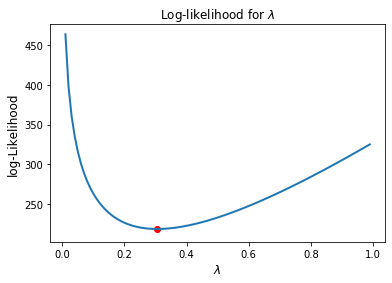

In [24]:
optRes = sp.optimize.minimize(fun=logLikeTruncExp, x0 = np.log(1), args = (y,c))
MLElambda = np.exp(optRes.x)
print('ML for lambda (numerical optimization) = ' + str(MLElambda))
print('Optimization terminated successfully: ' + str(optRes.success))

# Plot the log-likelihood
lambdaGrid = np.arange(0.01,1,0.01)
logLikeEvals = np.zeros(len(lambdaGrid))
for count, lambda_ in enumerate(lambdaGrid):
    logLikeEvals[count] = logLikeTruncExp(np.log(lambda_), y = y, c = 5)

plt.plot(lambdaGrid, logLikeEvals, linewidth = 2)
plt.xlabel('$\lambda$', fontsize=12);plt.ylabel('log-Likelihood', fontsize=12);plt.title('Log-likelihood for $\lambda$');
plt.scatter(MLElambda,logLikeTruncExp(np.log(MLElambda),y=y,c=c),color='r');


## ML estimation of truncated normal data
Now assume that you have a sample of independent normal data which is truncated at som level $c$:
  \begin{cases} 
    Y \sim \mathrm{N}(\mu,\sigma^2) &  \text{ if }Y\leq c \\
    Y=c & \text{ if }Y>c
  \end{cases}
  
Here we can not obtain a closed form solution for the ML estimate of $\mu$ and $\sigma^2$. But we can use numerical optimization, just like before. Let's first define the log-likelihood. The probability $\mathrm{Pr}(Y>c)$ can be computed with the scipy functions <tt>scipy.stats.norm.logpdf</tt>  and <tt>scipy.stats.norm.logcdf</tt>. 

In [25]:
from scipy.stats import norm
def logLikeTruncNormal(param,y,c):
    mu = param[0]
    sigma2 = np.exp(param[1]) # this way param[0] can be unrestricted and sigma2 remains positive (as it should)
    sigma = np.sqrt(sigma2)
    n = len(y)
    nu = sum(y<=c) # Number of non-truncated observations
    logL = np.sum(norm.logpdf(y[y<=c],mu,sigma)) + (n-nu)*(1-norm.logcdf(c,mu,sigma))
    return(-logL)

In [26]:
# Simulate some data and compute ML estimate
n = 100
c = 5
mu = 2
sigma2 = 2
y = np.random.normal(size = (n,1), loc = mu, scale = np.sqrt(sigma2))
y[y>c] = c 

# Find ML estimates
optRes = sp.optimize.minimize(fun=logLikeTruncNormal, x0 = (0,np.log(1)), args = (y,c))
MLEmu = optRes.x[0]
MLEsigma2 = np.exp(optRes.x[1])

print('MLE for mu = ' + str(MLEmu))
print('MLE for sigma2 = ' + str(MLEsigma2))
print('Optimization terminated successfully: ' + str(optRes.success))

MLE for mu = 1.9691552773277305
MLE for sigma2 = 1.8969972475445511
Optimization terminated successfully: True


## Maximum likelihood for logistic regression by numerical maximization

Logistic regression model:

$$
\mathrm{Pr}(Y = y \vert \mathbf{x}) = \frac{(\exp (\mathbf{x}^\top \mathbf{w}))^y}{1 + \exp (\mathbf{x}^\top \mathbf{w})}\text{ for }y \in  \{0,1\}
$$

and so the likelihood for a sample of independent data $(y_1,\mathbf{x}_1),\ldots,(y_n,\mathbf{x}_n)$ is

$$
p(y_1,\ldots,y_n\vert \mathbf{w}) =  \prod_{i=1}^n \frac{(\exp (\mathbf{x}_i^\top \mathbf{w}))^{y_i}}{1 + \exp (\mathbf{x}_i^\top \mathbf{w})}
$$
and the log-likelihood

$$
\log p(y_1,\ldots,y_n\vert \mathbf{w}) =  \sum_{i=1}^n y_i \mathbf{x}_i^\top \mathbf{w}
                                          - \sum_{i=1}^n \log \big(1 + \exp (\mathbf{x}_i^\top \mathbf{w})\big)
$$

The following function defines the log-likelihood function

In [147]:
def LogLikeLogisticReg(w, y, X, neg):
    n = len(y)
    linPred = X@w # matrix product. End result is n-by-1 and linPred[i] = x_i^T*w
    logLike = np.sum(y*linPred) - np.sum(np.log(1+np.exp(linPred)))
    if neg: logLike = -logLike
    return(logLike)

Let's try to find the MLE for some simulated data:

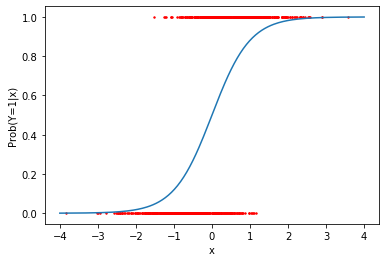

In [167]:
# Let's simulate some data
n = 1000
w = np.array([0,2])
x = np.random.normal(size=(n,1))
X = np.hstack([np.ones((n,1)),x])
def Logit(w,x):
    return(np.exp(w[0] + w[1]*x)/(1 + np.exp(w[0] + w[1]*x)))
y = np.random.binomial(n=1, p = Logit(w,x), size = (n,1))
y = np.ravel(y) # Convert it to a (n,) vector
xGrid = np.linspace(-4,4,200)
plt.plot(xGrid,Logit(w,xGrid))
plt.scatter(x,y,color = "red", s = 2)
plt.xlabel('x');plt.ylabel('Prob(Y=1|x)');

Although you can find many implementations of the logistic regression in Python, let us do it ourselves:

In [168]:
# Find ML estimates for logistic regression
optRes = sp.optimize.minimize(fun=LogLikeLogisticReg, x0 = (0,0), args = (y,X,True))
MLEw0 = optRes.x[0]
MLEw1 = optRes.x[1]

print('MLE for w0 = ' + str(MLEw0))
print('MLE for w1 = ' + str(MLEw1))
print('Optimization terminated successfully: ' + str(optRes.success))

MLE for w0 = 0.14174465082745946
MLE for w1 = 2.2732360438557775
Optimization terminated successfully: True


#### Plot the log-likelhood for w1, for w0=0.

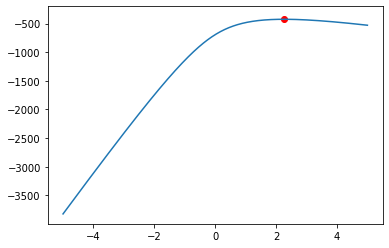

In [173]:
wSlopes = np.linspace(-5,5,500)
logLikes = [LogLikeLogisticReg(w=(0,wSlope), y = y, X = X, neg = False) for wSlope in wSlopes]
plt.plot(wSlopes,logLikes);
plt.scatter(MLEw1,LogLikeLogisticReg(w=(MLEw0,MLEw1), y = y, X = X, neg = False),color = "red");

## Alternative way using the Bernoulli distribution in scipy.stats
Let's repeat the log-likelihood function for logistic regression, but this time using scipy's built-in distributions.
This will serve as a template for other models, for example Poisson regression.
Note that a binomial distribution with parameter n=1 is the Bernoulli distribution.

In [171]:
def LogLikeLogisticReg(w, y, X, neg):
    from scipy.stats import binom
    linPred = X@w # matrix product. End result is n-by-1 and linPred[i] = x_i^T*w
    probs = np.exp(X@w)/(1 + np.exp(X@w)) # This is probability computed with the logistic function
    logLike = binom.logpmf(y, n = 1, p = probs) # Log of Bernoulli probability mass function (pdf for discrete variables)
    if neg: logLike = -logLike # set neg = True if you are using this function for minimization
    return(sum(logLike))

In [176]:
# Find ML estimates for logistic regression
optRes = sp.optimize.minimize(fun=LogLikeLogisticReg, x0 = (0,0), args = (y,X,True))
MLEw0 = optRes.x[0]
MLEw1 = optRes.x[1]

print('MLE for w0 = ' + str(MLEw0))
print('MLE for w1 = ' + str(MLEw1))
print('Optimization terminated successfully: ' + str(optRes.success))

MLE for w0 = 0.14174482041658562
MLE for w1 = 2.273236395834468
Optimization terminated successfully: True


Same result of course.